In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [2]:
df=pd.read_csv('daily_Queue1.csv',parse_dates=['Date'],index_col='Date')

In [3]:
df.head()

,BCST,ETS,Res_SST,Residential
Date,,,,
2017-01-01,NaN,243.0,NaN,NaN
2017-01-02,NaN,388.0,NaN,1.0
2017-01-03,829.0,878.0,2528.0,4216.0
2017-01-04,620.0,745.0,1520.0,3306.0
2017-01-05,467.0,631.0,1185.0,2406.0


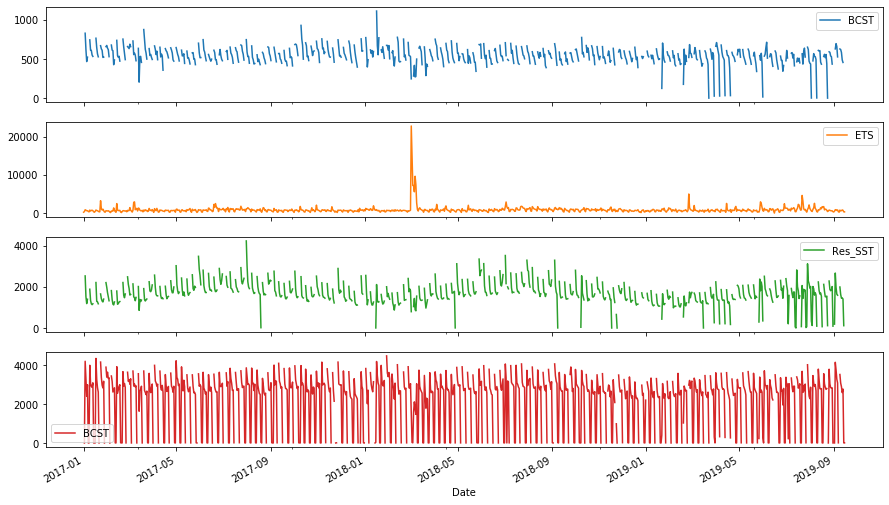

In [4]:
df.plot(subplots=True,figsize=(15, 9))
plt.legend(['BCST','ETS','Res_SST','Residential'])
plt.show()

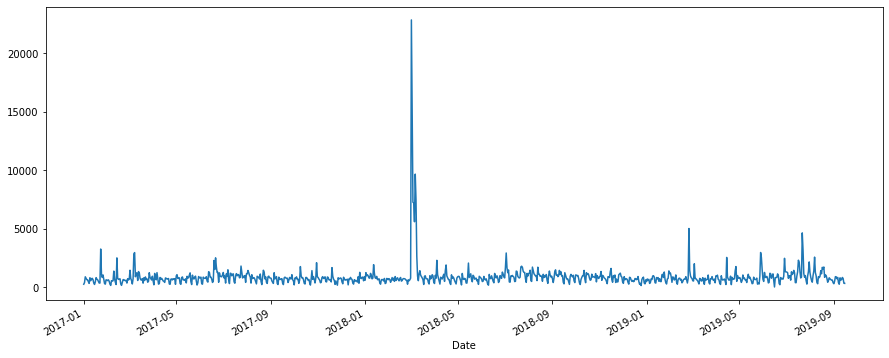

In [5]:
# plot ETS
df.ETS.plot(figsize=(15,6))
plt.show()

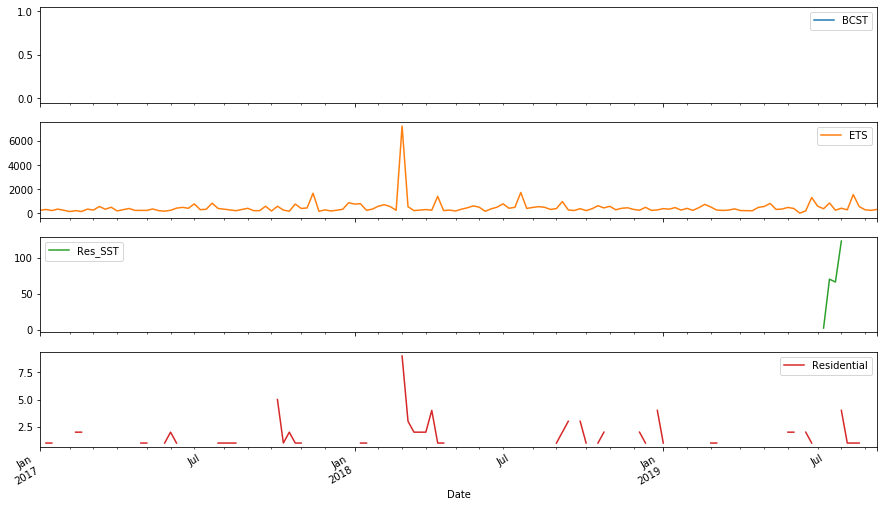

In [6]:
# look at only holiday
# ETS is in business during the whole week
# so we can analyze ETS individually
df.asfreq(freq='W').plot(subplots=True,figsize=(15, 9))
plt.show()

In [7]:
#extract ETS to analyze individually
ETS=df.drop(['BCST','Res_SST','Residential'],axis=1) 

In [8]:
# business day
business=df.asfreq(freq='B').drop('ETS',axis=1)

In [9]:
# check missing value
# there is missing value since other holidays like individual day, Christmas
# we have to replace them with other values
business.isnull().sum()

BCST           25
Res_SST        20
Residential    10
dtype: int64

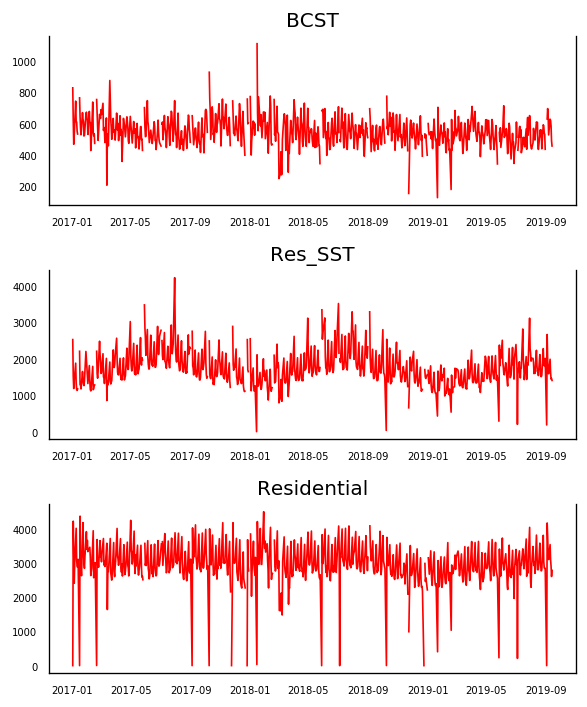

In [10]:
#plot multiple siries

fig, axes = plt.subplots(nrows=3, ncols=1, dpi=120, figsize=(5,6)) 
for i, ax in enumerate(axes.flatten()):
    data = business[business.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(business.columns[i])  
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

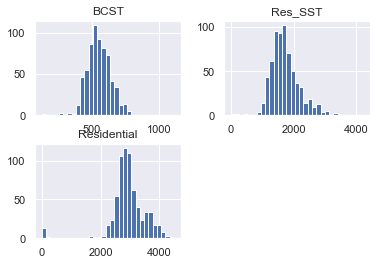

In [11]:
# EDA
bins=int(round(np.sqrt(987)))
sns.set()
business.hist(bins=bins)
plt.legend(['BCST','Res_SST','Residential'])
plt.show()

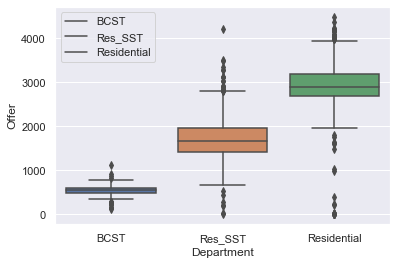

In [12]:
sns.boxplot(data=business)
plt.xlabel('Department')
plt.ylabel('Offer')
plt.legend(['BCST','Res_SST','Residential'])
plt.show()

In [13]:
# calculate IQR
IQR=business.quantile(0.75)-business.quantile(0.25)

In [14]:
# low outliers
business.quantile(0.25)-2*IQR

BCST            258.5
Res_SST         316.0
Residential    1658.5
dtype: float64

In [15]:
# high outliers
business.quantile(0.75)+2*IQR

BCST            839.75
Res_SST        3076.00
Residential    4223.50
dtype: float64

In [16]:
# treat outliers
business['BCST']=np.where((business['BCST'] <259)|
                          (business['BCST'] >840), np.nan,business['BCST'])

business['Res_SST']=np.where((business['Res_SST'] <316)|
                             (business['Res_SST'] >3022), np.nan,business['Res_SST'])

business['Residential']=np.where((business['Residential'] <1679)|
                                 (business['Residential'] >4201),np.nan,business['Residential'])

In [17]:
business['BCST'].isnull().sum()

33

In [18]:
business['Res_SST'].isnull().sum()

35

In [19]:
business['Residential'].isnull().sum()

37

In [20]:
# fill outliers
business.interpolate(method='linear',inplace=True)

In [21]:
# fill NAN
business.fillna(method='bfill',inplace=True)

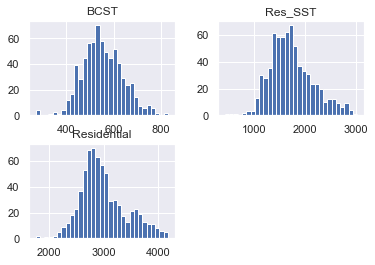

In [22]:
# the distribution looks much better than before
business.hist(bins=bins)
plt.show()

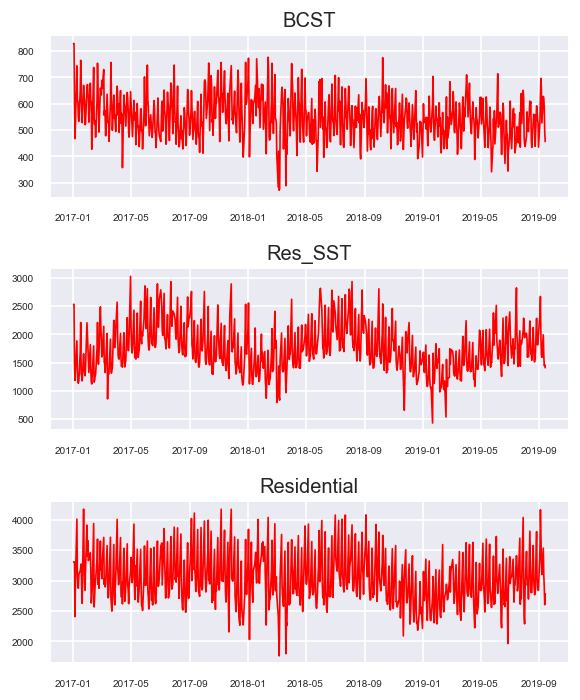

In [23]:
##plot multiple siries
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=120, figsize=(5,6)) 
for i, ax in enumerate(axes.flatten()):
    data = business[business.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(business.columns[i])  
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [24]:
# split training test
nobs = 90
df_train, df_test = business[0:-nobs], business[-nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)  

(615, 3)
(90, 3)


In [25]:
# ADF function
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [26]:
# ADF Test on each column
for name, column in df_train.iteritems():   # df_train
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "BCST" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.9568
 No. Lags Chosen       = 19
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0017. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Res_SST" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.3182
 No. Lags Chosen       = 19
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.6208. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Residential" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-St

In [27]:
#differencing
df_differenced = df_train.diff().dropna() 

In [28]:
# ADF Test on each column
#Now it is stationary
for name, column in df_differenced.iteritems(): # df_differenced
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "BCST" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.2471
 No. Lags Chosen       = 18
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Res_SST" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -15.5396
 No. Lags Chosen       = 18
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Residential" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Le

In [29]:
# import for Granger's Causality Test
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=20
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df
#result
grangers_causation_matrix(business, variables = business.columns)   ##df

,BCST_x,Res_SST_x,Residential_x
BCST_y,1.0,0.0,0.0
Res_SST_y,0.0,1.0,0.0
Residential_y,0.0,0.0,1.0


In [30]:
#####Cointegration test
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)
# result 
cointegration_test(business) ###df

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
BCST   ::  92.37     > 24.2761   =>   True
Res_SST ::  28.36     > 12.3212   =>   True
Residential ::  0.24      > 4.1296    =>   False


In [31]:
# choose order P for AR 
# Lag Order=25 has the lowest AIC
model = VAR(df_differenced)
x= range(1,70)
for i in x:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  31.43532743133956
BIC :  31.52182070904141
FPE :  44894121913445.06
HQIC:  31.468965150193277 

Lag Order = 2
AIC :  31.020204586558975
BIC :  31.17175912566479
FPE :  29641827753108.26
HQIC:  31.079149321706193 

Lag Order = 3
AIC :  30.655509680555515
BIC :  30.872290218649045
FPE :  20583655409733.914
HQIC:  30.739829233327967 

Lag Order = 4
AIC :  30.26428348829422
BIC :  30.5464554544082
FPE :  13919374744137.3
HQIC:  30.374045950679296 

Lag Order = 5
AIC :  30.160880129301848
BIC :  30.508609647939082
FPE :  12552191823367.77
HQIC:  30.296153885647474 

Lag Order = 6
AIC :  30.14658347483868
BIC :  30.560037370023007
FPE :  12374320895951.61
HQIC:  30.307437203570885 

Lag Order = 7
AIC :  30.16061015503926
BIC :  30.639955954396637
FPE :  12549544060306.238
HQIC:  30.347112830392536 

Lag Order = 8
AIC :  30.070223381818106
BIC :  30.615629320688072
FPE :  11465503487041.014
HQIC:  30.28244427557864 

Lag Order = 9
AIC :  29.888773930332476
BIC :  30.50040

In [32]:
# fit model
model_fitted = model.fit(25)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 11, Jul, 2020
Time:                     22:50:02
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    31.4252
Nobs:                     589.000    HQIC:                   30.3906
Log likelihood:          -11034.8    FPE:                8.19585e+12
AIC:                      29.7303    Det(Omega_mle):     5.69476e+12
--------------------------------------------------------------------
Results for equation BCST
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                  -0.889324         2.480269           -0.359           0.720
L1.BCST                -0.679795         0.055318          -12.289           0.000
L1.Res_SST              0.012561         0.013932    

In [33]:
##Durbin-Watson Statistic: 
#Serial Correlation of Residuals (1.5-2.5) close to 2, better
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df_differenced.columns, out): # df_diff
    print((col), ':', round(val, 2))

BCST : 2.0
Res_SST : 2.01
Residential : 2.0


In [34]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

25


In [35]:
# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

array([[ 128.,  508.,  852.],
       [ -90., -445., -691.],
       [ -56.,  -82., -133.],
       [ -21.,   20.,   20.],
       [ -25.,   -9.,  -64.],
       [ 121.,  505.,  901.],
       [ -60., -487., -738.],
       [  -3., -159., -309.],
       [ -29.,   55., -160.],
       [-127., -185., -197.],
       [ 197.,  540., 1074.],
       [ -38., -198., -550.],
       [ -11.,  -35., -296.],
       [ -23.,   18.,   67.],
       [ -43.,  -18.,   50.],
       [  84.,  687.,  714.],
       [  70.,  -36., -378.],
       [ -27., -135.,  -69.],
       [  28., -338.,    4.],
       [-102., -104.,   15.],
       [  97.,  607.,  760.],
       [ -79., -442., -663.],
       [ -33., -167., -131.],
       [ -35.,  -18., -118.],
       [ -39.,  -81., -220.]])

In [36]:
# Forecast
fc = model_fitted.forecast(y=forecast_input,steps=nobs)
df_forecast = pd.DataFrame(fc, index=business.index[-nobs:], columns=business.columns) #df
df_forecast.head()

,BCST,Res_SST,Residential
Date,,,
2019-05-13,165.379557,550.466414,949.644301
2019-05-14,-50.367473,-457.030921,-590.907992
2019-05-15,-8.814766,-91.895469,-155.694201
2019-05-16,-43.375826,-131.216685,-152.274732
2019-05-17,-64.463877,-47.055768,-19.842627


In [37]:
business.iloc[-1]

BCST            456.0
Res_SST        1408.0
Residential    2782.0
Name: 2019-09-13 00:00:00, dtype: float64

In [38]:
# transform to original
df_forecast.BCST=df_forecast.BCST.cumsum()+456
df_forecast.Res_SST=df_forecast.Res_SST.cumsum()+1408
df_forecast.Residential=df_forecast.Residential.cumsum()+2782

In [39]:
# Evaluation
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

In [40]:
print('Forecast Accuracy of: BCST')
accuracy_prod = forecast_accuracy(df_forecast['BCST'].values, df_test['BCST']) #f
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

Forecast Accuracy of: BCST
mape :  0.1096
me :  23.8703
mae :  54.0825
mpe :  0.0611
rmse :  67.4879
corr :  0.5629
minmax :  0.0956


In [41]:
print('Forecast Accuracy of: Res_SST')
accuracy_prod = forecast_accuracy(df_forecast['Res_SST'].values, df_test['Res_SST']) #f
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

Forecast Accuracy of: Res_SST
mape :  0.1175
me :  -212.1837
mae :  229.2165
mpe :  -0.1065
rmse :  294.305
corr :  0.7564
minmax :  0.1171


In [42]:
print('Forecast Accuracy of: Residential')
accuracy_prod = forecast_accuracy(df_forecast['Residential'].values, df_test['Residential'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

Forecast Accuracy of: Residential
mape :  0.075
me :  93.3672
mae :  213.9938
mpe :  0.0415
rmse :  293.7149
corr :  0.7271
minmax :  0.0673


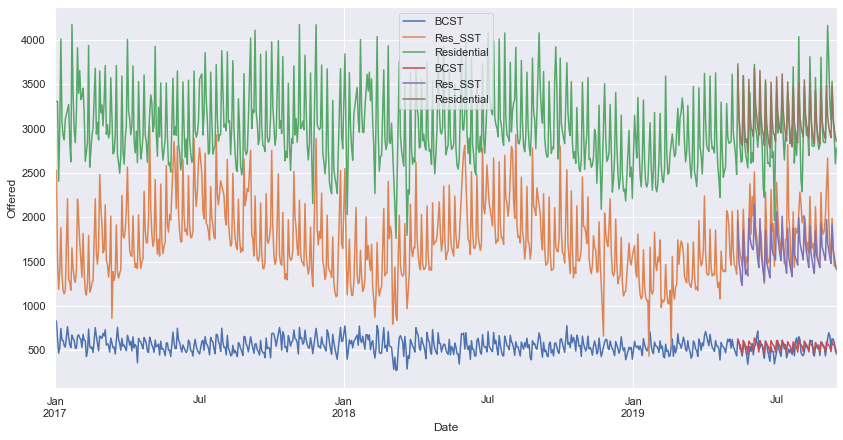

In [43]:
# visualize forecast
ax = business.plot(label='observed', figsize=(14, 7))
df_forecast.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Offered')
plt.legend()
plt.show()